In [30]:
%load_ext autoreload
%autoreload 2

from dfa import Dfa
from model import Rnn, Ngram, GaussianProbe
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

N_STATES = 8
N_SYMBOLS = 64
N_CONNECTIONS = 2 * N_SYMBOLS // N_STATES

N_ITERS = 1000

def train_model(dfa, rand, train):
    return Rnn.train(dfa, rand, 128, 256, max_iters=(N_ITERS if train else 0), model_type="lstm")

def train_ngram_model(dfa, rand, max_order):
    return Ngram.train(dfa, rand, max_order, n_samples=64 * N_ITERS * 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def run_experiment1(dfa, data_rand, train=True):
    rnn = train_model(dfa, data_rand, train)
    
    probe_data = [dfa.sample(data_rand) for _ in range(100)]
    probe = GaussianProbe.train(dfa, rnn, probe_data)
    
    eval_data = [dfa.sample(data_rand) for _ in range(100)]
    eval_anns = [dfa.annotate(seq) for seq in eval_data]
    in_dist_stats = probe.eval(rnn, eval_data, eval_anns)
    
    ghost_symbols = []
    ghost_states = []
    eval_indices = []
    for i in range(100):
        prefix = dfa.sample(data_rand)
        if len(prefix) == 0:
            continue
        prefix_ann = dfa.annotate(prefix)
        prefix_len = data_rand.randint(len(prefix))
        # TODO beautify
        ghost_symbol = np.random.randint(dfa.n_symbols)
        prefix_symbols = prefix[:prefix_len]
        prefix_states = prefix_ann[:prefix_len+1]
        ghost_symbols.append(prefix_symbols + (ghost_symbol,))
        ghost_states.append(prefix_states + [0])
        eval_indices.append([prefix_len+1])
        assert len(ghost_symbols[-1]) == len(ghost_states[-1]) - 1
        
    ghost_stats = probe.eval(rnn, ghost_symbols, ghost_states, eval_indices=eval_indices)
    
    return [
        {
            "n_states": dfa.n_states,
            "n_symbols": dfa.n_symbols,
            "n_neighbors": dfa.n_neighbors,
            "train": train,
            "eval_set": "in_dist",
            "accuracy": in_dist_stats["accuracy"],
            "confidence": in_dist_stats["confidence"],
            "error": in_dist_stats["error"],
        },
        {
            "n_states": dfa.n_states,
            "n_symbols": dfa.n_symbols,
            "n_neighbors": dfa.n_neighbors,
            "train": train,
            "eval_set": "ghost",
            "accuracy": ghost_stats["accuracy"],
            "confidence": ghost_stats["confidence"],
            "error": ghost_stats["error"],
        }
    ]

In [3]:
results1 = []

dfa_rand = np.random.RandomState(0)
data_rand = np.random.RandomState(0)
for i in tqdm(range(10)):
    dfa = Dfa.generate(dfa_rand, N_STATES, N_SYMBOLS, N_CONNECTIONS)
    results1 += run_experiment1(dfa, data_rand)
    results1 += run_experiment1(dfa, data_rand, train=False)
    
results1 = pd.DataFrame(results1)

100%|██████████| 10/10 [05:02<00:00, 30.23s/it]


## (1a) DFA states are predictable from RNN states in trained models

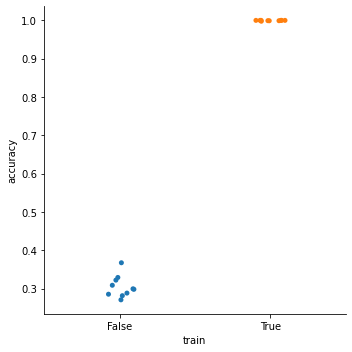

In [4]:
sns.catplot(data=results1.query("eval_set=='in_dist'"), x="train", y="accuracy")

## (1b): RNN states after ghost transitions are far from any cluster

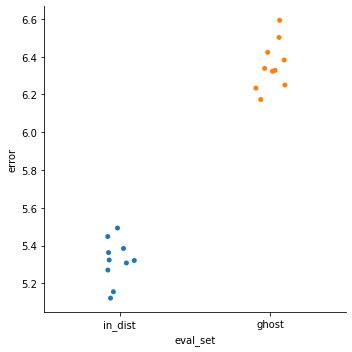

In [5]:
sns.catplot(data=results1.query("train==True"), x="eval_set", y="error")

## (1c) But probe predictions are still confident after ghost transitions

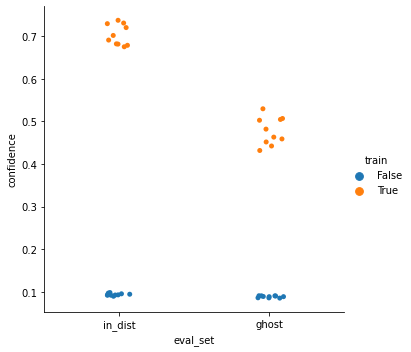

In [6]:
sns.catplot(data=results1, x="eval_set", y="confidence", hue="train")

## (2a) Probes predict post-transition behavior

In [1]:
def run_experiment2a(dfa, data_rand, transitioner_name, transitioner):
    rnn = train_model(dfa, data_rand, train=True)
    #ngram = train_ngram_model(dfa, data_rand, max_order=5)
    ngram = None
    
    probe_data = [dfa.sample(data_rand) for _ in range(100)]
    probe = GaussianProbe.train(dfa, rnn, probe_data)
    
    ghost_symbols = []
    for i in range(100):
        prefix = dfa.sample(data_rand)
        if len(prefix) == 0:
            continue
        prefix_len = data_rand.randint(len(prefix))
        ghost_symbol = np.random.randint(dfa.n_symbols)
        prefix_symbols = prefix[:prefix_len]
        # TODO beautify
        ann = dfa.annotate(prefix_symbols)
        prefix_state = ann[-1]
        edges = dfa.edges[prefix_state]
        forbidden_symbols = [sym for sym, dst in edges]
        ghost_choices = [i for i in range(dfa.n_symbols) if i not in forbidden_symbols]
        if len(ghost_choices) == 0:
            continue
        ghost_symbol = data_rand.choice(ghost_choices)
        ghost_symbols.append(prefix_symbols + (ghost_symbol,))
    
    pred_states = probe.predict(rnn, ghost_symbols)
    ngram_pred_states = ngram(ghost_symbols)
    
    all_symbols = []
    eval_indices = []
    for i in range(len(ghost_symbols)):
        true_states = dfa.annotate(ghost_symbols[i][:-1], allow_incomplete=True)
        resume_from = transitioner(dfa, pred_states[i], true_states, ngram_states=ngram_pred_states)
        suffix = dfa.sample(data_rand, start_state=resume_from)
        symbols = ghost_symbols[i] + suffix
        all_symbols.append(symbols)
        eval_indices.append(list(range(len(ghost_symbols[i]), len(symbols))))
        
    ppl = rnn.predict(all_symbols, eval_indices=eval_indices)
    norm_ppl = ppl / np.log(dfa.n_neighbors)
    
    return [
        {
            "n_states": dfa.n_states,
            "n_symbols": dfa.n_symbols,
            "n_neighbors": dfa.n_neighbors,
            "transitioner": transitioner_name,
            "norm_ppl": norm_ppl,
        }
    ]

In [8]:
results2a = []

def identity_transitioner(dfa, pred_states, true_states, **kwargs):
    return true_states[-1]

def probe_transitioner(dfa, pred_states, true_states, **kwargs):
    return pred_states[-1]

def ngram_transitioner(dfa, pred_states, true_states, ngram_states, **kwargs):
    return ngram_states

dfa_rand = np.random.RandomState(0)
data_rand = np.random.RandomState(0)
for i in tqdm(range(10)):
    dfa = Dfa.generate(dfa_rand, N_STATES, N_SYMBOLS, N_CONNECTIONS)
    for name, transitioner in [
        ("identity", identity_transitioner),
        ("probe", probe_transitioner),
        ("ngram", ngram_transitioner),
    ]:
        results2a += run_experiment2a(dfa, data_rand, name, transitioner)
    
results2a = pd.DataFrame(results2a)

100%|██████████| 10/10 [09:02<00:00, 54.27s/it]


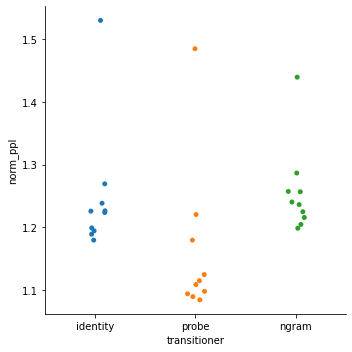

In [9]:
sns.catplot(data=results2a, x="transitioner", y="norm_ppl")

## (2b) ?? predicts probe behavior

In [48]:
def run_experiment2b(dfa, data_rand, hypotheses):
    rnn = train_model(dfa, data_rand, train=True)
    copycat_rnn = train_model(dfa, data_rand, train=True)
    ngram = train_ngram_model(dfa, data_rand, max_order=5)
    #ngram = None
    
    probe_data = [dfa.sample(data_rand) for _ in range(100)]
    probe = GaussianProbe.train(dfa, rnn, probe_data)
    copycat_probe = GaussianProbe.train(dfa, copycat_rnn, probe_data)
    
    unused_symbols = []
    for i in range(dfa.n_symbols):
        used = False
        for edges in dfa.edges:
            for sym, _ in edges:
                if sym == i:
                    used = True
        if not used:
            unused_symbols.append(i)
    
    ghost_symbols = []
    while len(ghost_symbols) < 100:
        prefix = dfa.sample(data_rand)
        if len(prefix) == 0:
            continue
        prefix_len = data_rand.randint(len(prefix))
        prefix_symbols = prefix[:prefix_len]
        ann = dfa.annotate(prefix_symbols)
        prefix_state = ann[-1]
        edges = dfa.edges[prefix_state]
        forbidden_symbols = [sym for sym, dst in edges] + unused_symbols
        ghost_choices = [i for i in range(dfa.n_symbols) if i not in forbidden_symbols]
        if len(ghost_choices) == 0:
            continue
        ghost_symbol = data_rand.choice(ghost_choices)
        #print("* ann / forbidden", ann, forbidden_symbols, ghost_symbol)
        
        #ghost_symbol = np.random.randint(dfa.n_symbols)
        
        ghost_symbols.append(prefix_symbols + (ghost_symbol,))
        
    pred_states = probe.predict(rnn, ghost_symbols)
    copycat_states = copycat_probe.predict(copycat_rnn, ghost_symbols)
    #pred_states = [p[-1] for p in pred_states]
    
    results = []
    for hypothesis_name, hypothesis in hypotheses:
        correct = 0
        total = 0
        for i in range(len(ghost_symbols)):
            true_states = dfa.annotate(ghost_symbols[i][:-1], allow_incomplete=True)
            # TODO not here
            if any(sym == ghost_symbols[i][-1] for sym, _ in dfa.edges[true_states[-1]]):
                continue
            hyp_state = hypothesis(
                dfa, pred_states[i], true_states, ghost_symbols[i], probe,
                ngram=ngram, copycat_states=copycat_states[i]
            )
            if hyp_state == pred_states[i][-1]:
                correct += 1
                #print("correct!")
            total += 1
        print(hypothesis_name, correct/total)
        results.append({
            "n_states": dfa.n_states,
            "n_symbols": dfa.n_symbols,
            "n_neighbors": dfa.n_neighbors,
            "hypothesis": hypothesis_name,
            "hyp_acc": correct / total,
        })
        #assert False
    return results

  0%|          | 0/10 [00:00<?, ?it/s]

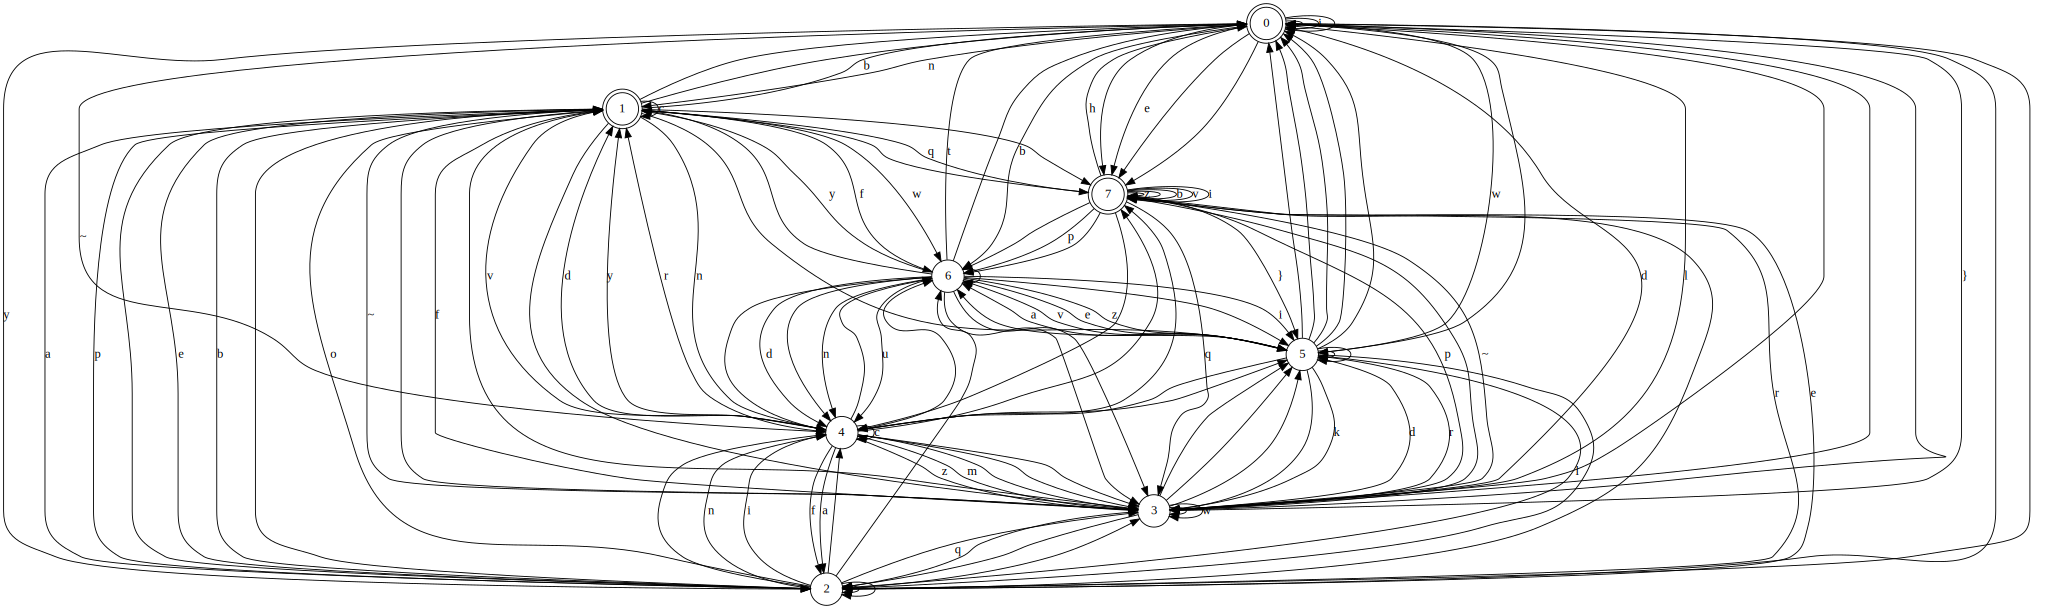


GT  is 2
ctx is ['\x9a', 'd', 'm', '\x86']
{2: 1.0}
Counter({2: 8519})
{0: 0.19273869391068058, 3: 0.1553191113934325, 7: 0.13247437051153108, 6: 0.09227815714714238, 5: 0.11778095389338838, 2: 0.10323787341414783, 1: 0.10501508654915039, 4: 0.10115575318052689}
Counter({0: 273077, 3: 220060, 7: 187693, 5: 166875, 1: 148788, 2: 146270, 4: 143320, 6: 130742})

GT  is 0
ctx is ['\x9a', 'y', '\x97', 'o', 'c', 'c', 'h']
{0: 1.0}
Counter({0: 10830})
{0: 0.19273869391068058, 3: 0.1553191113934325, 7: 0.13247437051153108, 6: 0.09227815714714238, 5: 0.11778095389338838, 2: 0.10323787341414783, 1: 0.10501508654915039, 4: 0.10115575318052689}
Counter({0: 273077, 3: 220060, 7: 187693, 5: 166875, 1: 148788, 2: 146270, 4: 143320, 6: 130742})

GT  is 7
ctx is ['l', 'w', '\x96', 'c', '\x8e', '\x8d', 'z', 'q', '\x9e', '\x7f', '~', 'c', '\x8b', '\x8e', '\x90', '\x89', 'b', 'n', 'v', 'q', '~', '\x91']
{6: 0.408200574562549, 7: 0.591799425437451}
Counter({7: 15862, 6: 10941})
{0: 0.19273869391068058, 3:

 10%|█         | 1/10 [00:43<06:33, 43.75s/it]

nearest_rep_with_in_edge 0.58
nearest_state_with_in_edge 0.6
oracle_out_edge 0.96
oracle_in_edge 0.97
both_edges 0.6


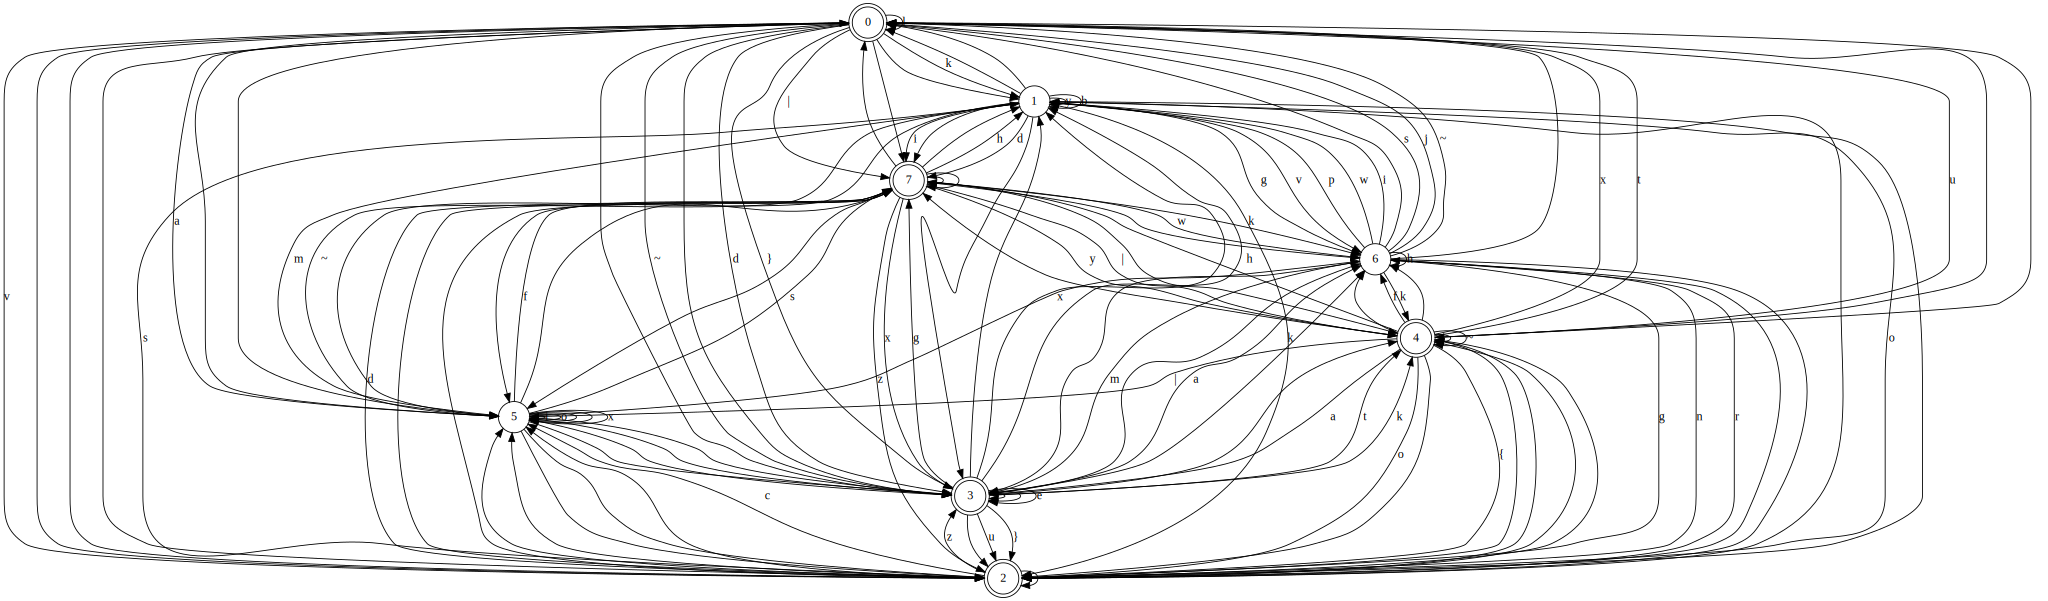


GT  is 0
ctx is ['~', '\x85']
{0: 1.0}
Counter({0: 10436})
{0: 0.1541413969522176, 4: 0.10638342683022374, 6: 0.09871721536241383, 3: 0.14174151051324022, 7: 0.11229062186454057, 1: 0.1036219058201709, 2: 0.15150287230197795, 5: 0.13160105035521516}
Counter({0: 182970, 2: 179838, 3: 168251, 5: 156214, 7: 133292, 4: 126280, 1: 123002, 6: 117180})

GT  is 5
ctx is ['~', '\x86', '\x92', '\x98', 'v', '\x97', '\x7f', 'w', 'k', '~', 'a', 'a', '\x97', 'v', '\x82', '\xa0']
{5: 0.7097394111768776, 3: 0.29026058882312245}
Counter({5: 18466, 3: 7552})
{0: 0.1541413969522176, 4: 0.10638342683022374, 6: 0.09871721536241383, 3: 0.14174151051324022, 7: 0.11229062186454057, 1: 0.1036219058201709, 2: 0.15150287230197795, 5: 0.13160105035521516}
Counter({0: 182970, 2: 179838, 3: 168251, 5: 156214, 7: 133292, 4: 126280, 1: 123002, 6: 117180})

GT  is 1
ctx is ['\x98']
{1: 1.0}
Counter({1: 10226})
{0: 0.1541413969522176, 4: 0.10638342683022374, 6: 0.09871721536241383, 3: 0.14174151051324022, 7: 0.1122906

labeled_most_in_edges 0.7
nearest_rep_with_in_edge 0.77
nearest_state_with_in_edge 0.75
oracle_out_edge 0.92
oracle_in_edge 0.99
both_edges 0.74


 20%|██        | 2/10 [01:23<05:41, 42.63s/it]

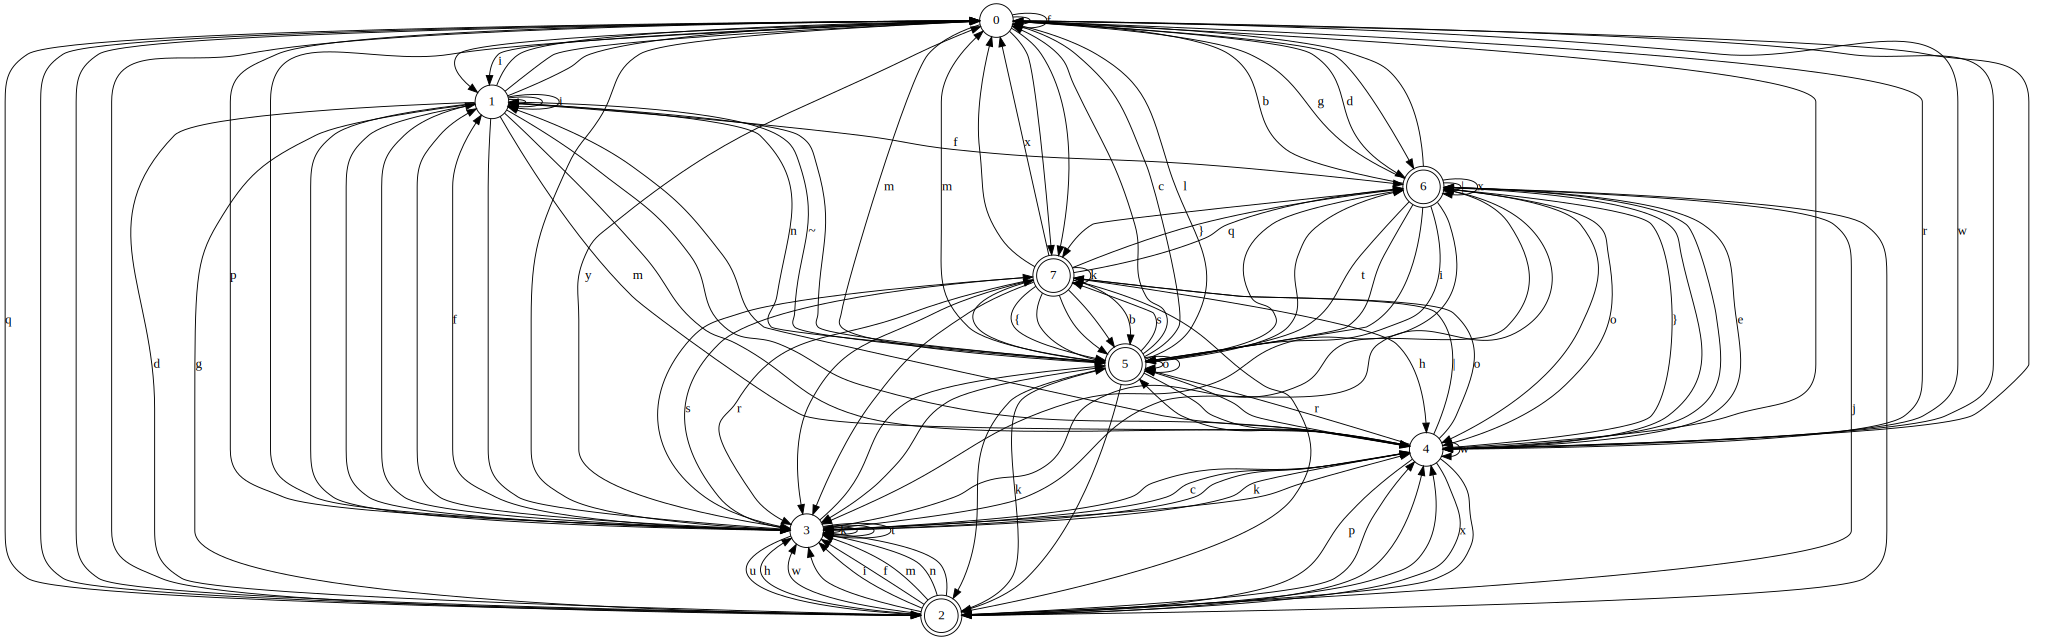


GT  is 3
ctx is ['\x83', '\x9d', '\x8e', 'p', '\x8e', 'f', '\x8d', 's', '\x91', '\x8e']
{3: 1.0}
Counter({3: 16955})
{0: 0.18400357527394806, 7: 0.07662830917341076, 3: 0.17912215585826857, 5: 0.12126935526026146, 6: 0.1074404403652153, 4: 0.14968732979042484, 2: 0.08589436049747916, 1: 0.09595447378099185}
Counter({0: 276679, 3: 269339, 4: 225079, 5: 182348, 6: 161554, 1: 144283, 2: 129156, 7: 115223})

GT  is 2
ctx is ['r', '\x93', '\x8d', '\x88', '\x99', '\x8a', 'i', '\x89', 'q', 'j', 'q']
{2: 0.7215686274509804, 6: 0.2784313725490196}
Counter({2: 17112, 6: 6603})
{0: 0.18400357527394806, 7: 0.07662830917341076, 3: 0.17912215585826857, 5: 0.12126935526026146, 6: 0.1074404403652153, 4: 0.14968732979042484, 2: 0.08589436049747916, 1: 0.09595447378099185}
Counter({0: 276679, 3: 269339, 4: 225079, 5: 182348, 6: 161554, 1: 144283, 2: 129156, 7: 115223})

GT  is 6
ctx is ['q', '\x8a', '\x8f', '\x93', '\x99', '\x94']
{6: 1.0}
Counter({6: 7567})
{0: 0.18400357527394806, 7: 0.07662830917341

nearest_rep_with_in_edge 0.69
nearest_state_with_in_edge 0.7
oracle_out_edge 0.98
oracle_in_edge 1.0
both_edges 0.64


 30%|███       | 3/10 [02:00<04:46, 40.98s/it]

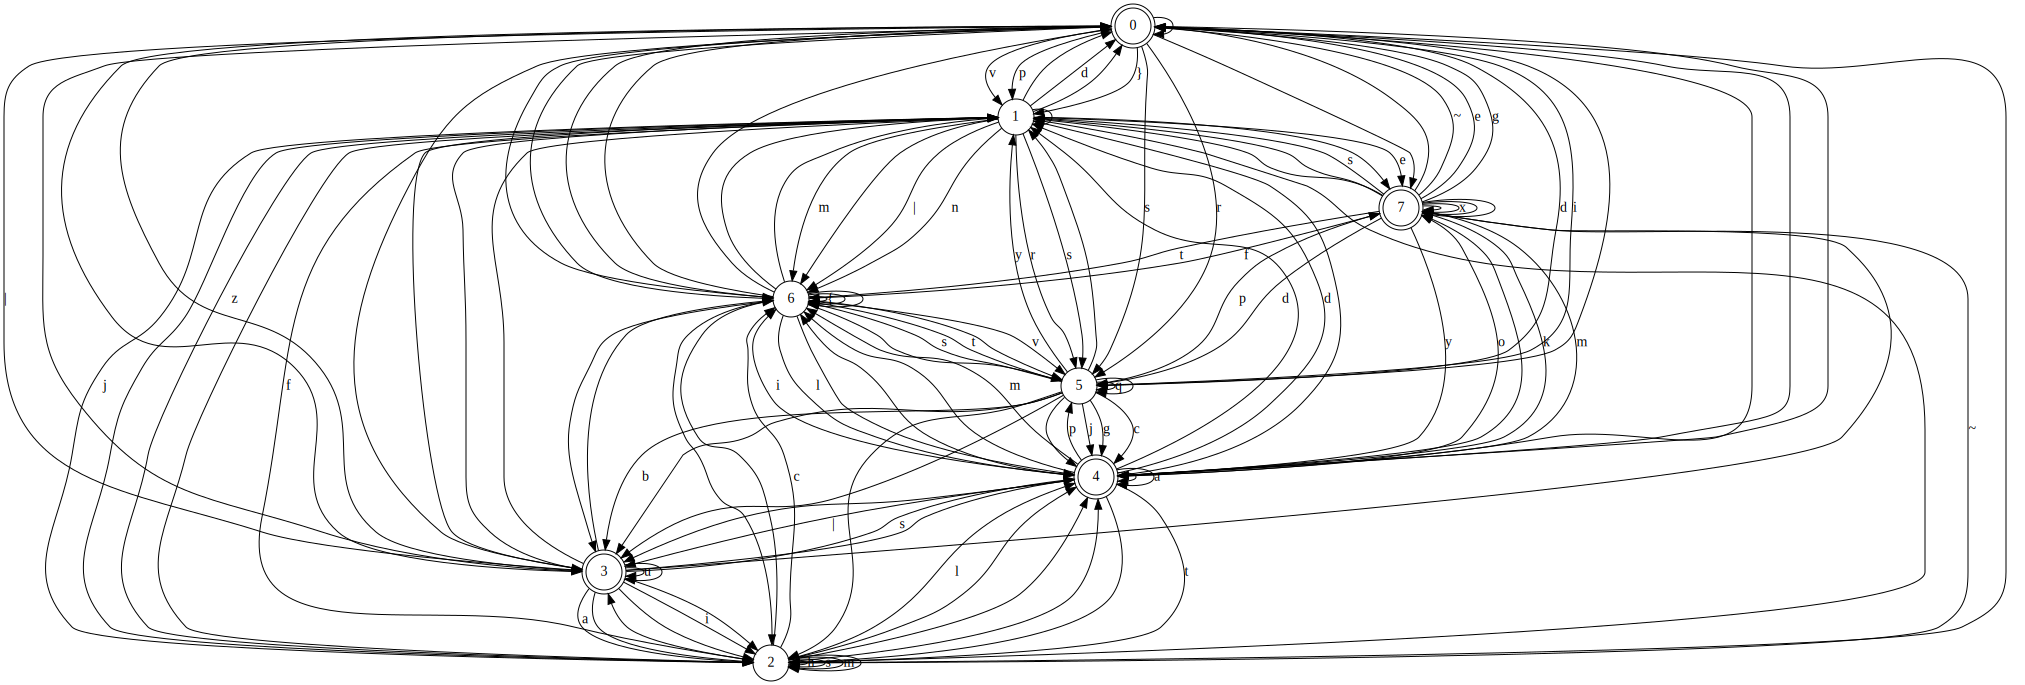


GT  is 4
ctx is ['\x9a', '\x86', 's', '\x94', 'r', 'p', '\x9b', '\x83', '\x9d', 'p', '\x86', 'm', '\x9f', 's', '\x95', 't', '\x81', 'k']
{4: 1.0}
Counter({4: 7169})
{0: 0.1603434870526654, 1: 0.14067845607365817, 6: 0.15139587588977754, 5: 0.10945891373764316, 7: 0.09275091966054393, 4: 0.14336774137549294, 2: 0.11148396910852693, 3: 0.0905206371016919}
Counter({0: 217982, 6: 205818, 4: 194904, 1: 191248, 2: 151559, 5: 148806, 7: 126092, 3: 123060})

GT  is 4
ctx is ['}', 'j', '\x9d', 'o', '\x8d', 'e', 'p', 'e', '\x96', 'd', 'g', '\x90', 'm', '\x85', 't', '\x9d', '\x94', '|', '\x9f', 'd', 'd', 'v', 'r', 'c', '\x87', '~', 'i', '\x9f', '\x86']
{4: 0.5540449092586897, 7: 0.44595509074131034}
Counter({4: 9006, 7: 7249})
{0: 0.1603434870526654, 1: 0.14067845607365817, 6: 0.15139587588977754, 5: 0.10945891373764316, 7: 0.09275091966054393, 4: 0.14336774137549294, 2: 0.11148396910852693, 3: 0.0905206371016919}
Counter({0: 217982, 6: 205818, 4: 194904, 1: 191248, 2: 151559, 5: 148806, 7: 1260

nearest_rep_with_in_edge 0.68
nearest_state_with_in_edge 0.76
oracle_out_edge 0.94
oracle_in_edge 0.98
both_edges 0.78


 40%|████      | 4/10 [02:39<04:01, 40.24s/it]

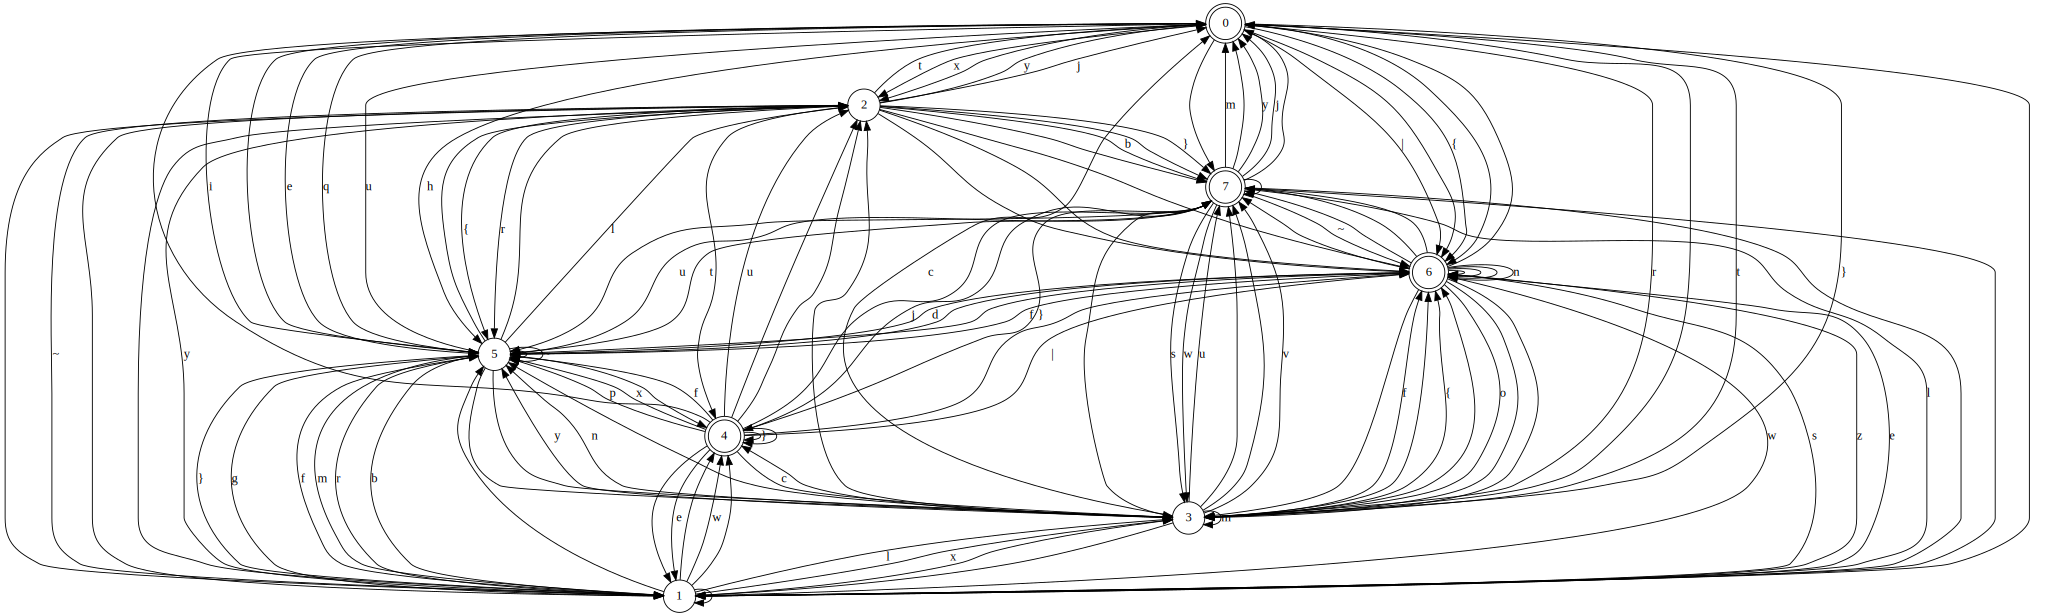


GT  is 1
ctx is ['x', '}', '\xa0', 'w', 'j', '\x8a', 'm', 'e', 'g', 'y', '\x81', 'x', 't', 'l', 'x', 'u', 's', 'l']
{2: 0.417397209532041, 1: 0.30716755154957404, 3: 0.275435238918385}
Counter({2: 13522, 1: 9951, 3: 8923})
{0: 0.13814403865811728, 3: 0.14761453396524488, 7: 0.12918204627822694, 6: 0.17794703094507947, 5: 0.16230536195520862, 1: 0.1088865347086702, 4: 0.05798791933835146, 2: 0.0779325341511012}
Counter({6: 239361, 5: 218321, 3: 198560, 0: 185821, 7: 173766, 1: 146466, 2: 104829, 4: 78001})

GT  is 7
ctx is ['t', '\x91', 'o', 'm', '\x95', 'n', '\x99', '\x9f', 'b']
{7: 0.42013753730374986, 5: 0.5798624626962502}
Counter({5: 8938, 7: 6476})
{0: 0.13814403865811728, 3: 0.14761453396524488, 7: 0.12918204627822694, 6: 0.17794703094507947, 5: 0.16230536195520862, 1: 0.1088865347086702, 4: 0.05798791933835146, 2: 0.0779325341511012}
Counter({6: 239361, 5: 218321, 3: 198560, 0: 185821, 7: 173766, 1: 146466, 2: 104829, 4: 78001})

GT  is 3
ctx is ['\x94']
{3: 0.6031523027615577,

both_edges 0.69


 50%|█████     | 5/10 [03:17<03:17, 39.54s/it]

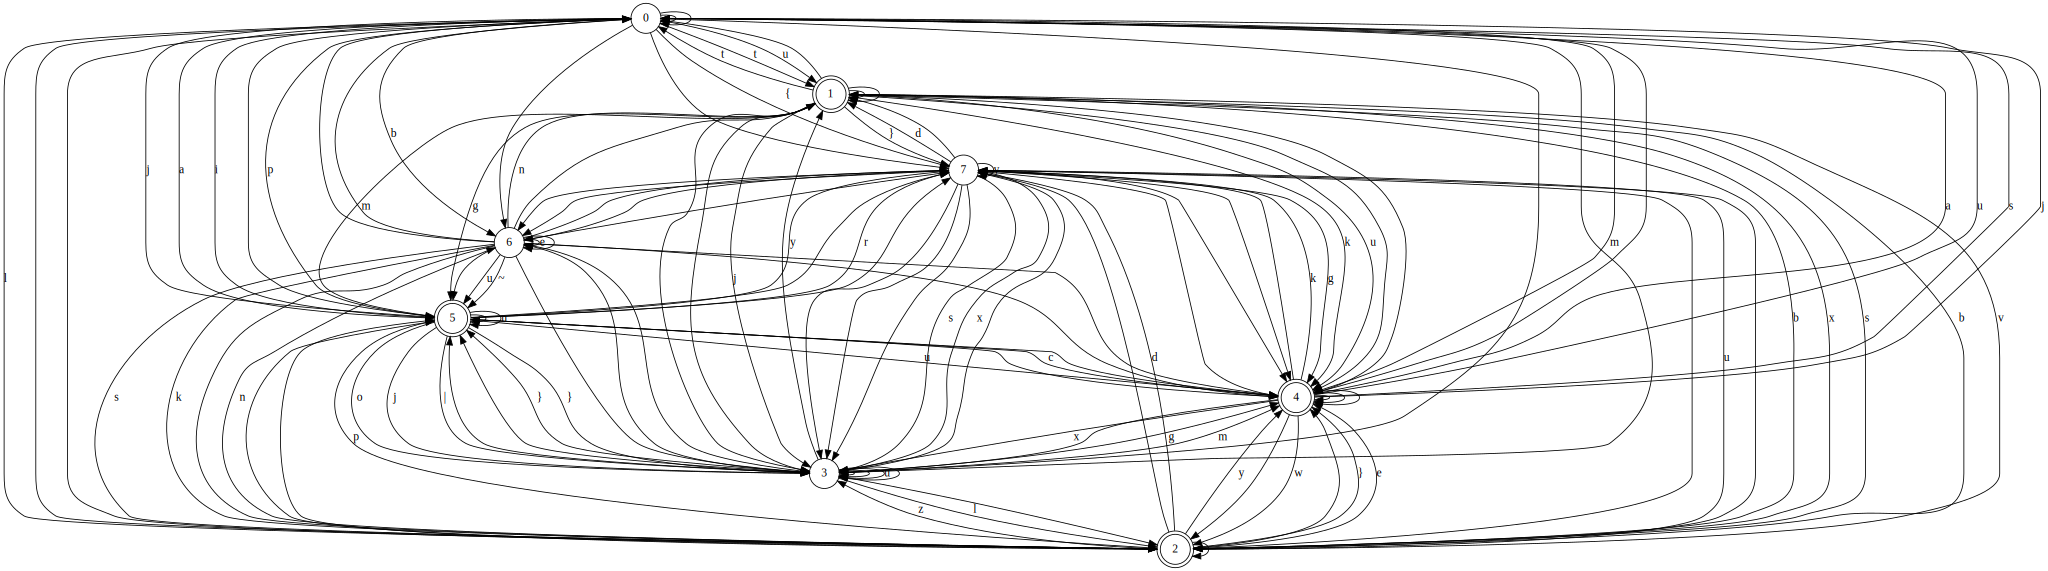


GT  is 0
ctx is ['\x89', '\x8d', '\x97', '\x95', '\x89']
{0: 0.3658476778971115, 6: 0.6341523221028885}
Counter({6: 12931, 0: 7460})
{0: 0.1487902434499024, 4: 0.16163175303197355, 7: 0.1276943442409451, 1: 0.08595569161823002, 3: 0.162082044365471, 2: 0.10853805175852681, 6: 0.08668786104480435, 5: 0.11862001049014675}
Counter({3: 227128, 4: 226497, 0: 208502, 7: 178940, 5: 166224, 2: 152096, 6: 121477, 1: 120451})

GT  is 3
ctx is ['a', 'y', '\x81', '\x93', 'u', '\x9b', '}', '\x84', 'b', '\x8c', 'a', '}', 'u', '\x81']
{3: 1.0}
Counter({3: 11097})
{0: 0.1487902434499024, 4: 0.16163175303197355, 7: 0.1276943442409451, 1: 0.08595569161823002, 3: 0.162082044365471, 2: 0.10853805175852681, 6: 0.08668786104480435, 5: 0.11862001049014675}
Counter({3: 227128, 4: 226497, 0: 208502, 7: 178940, 5: 166224, 2: 152096, 6: 121477, 1: 120451})

GT  is 2
ctx is ['a', 'o', 'g', 'x', '\x8c', '\x90', '\x83', '}', '\x95', 'a', '\x95', '\x90', '\x83', 'b', 'p', 'j', '\x8f', '\x8d', 'u', '\x96']
{2: 1.0}


nearest_rep_with_in_edge 0.62
nearest_state_with_in_edge 0.65
oracle_out_edge 0.96
oracle_in_edge 0.98
both_edges 0.67


 60%|██████    | 6/10 [03:57<02:39, 39.86s/it]

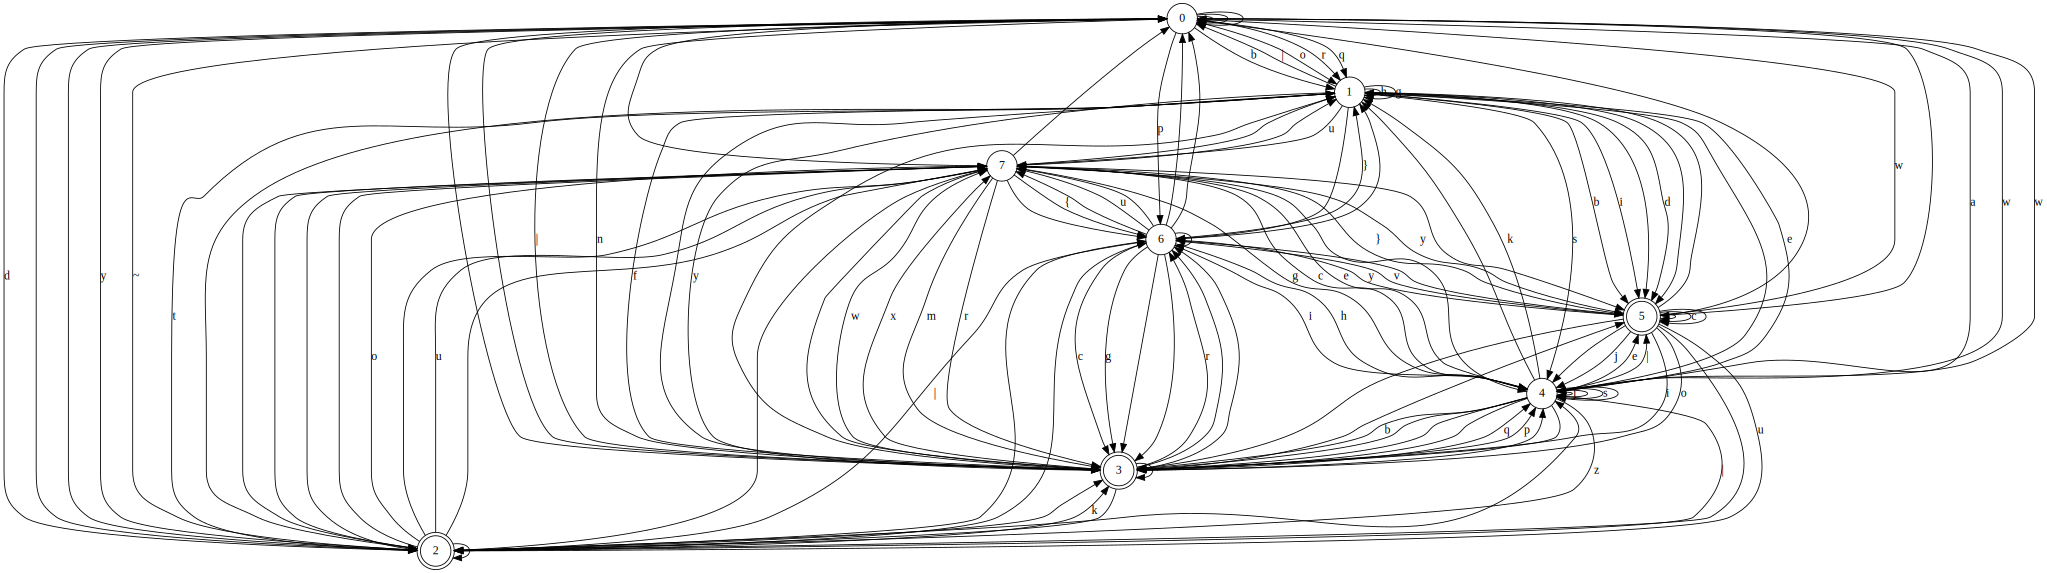


GT  is 5
ctx is ['\x81', 'p', '\x93', '\x9f', '\x9a', '\x9c', '\x80', 'm', '\x90', 'c', '\x90', '|']
{0: 0.44527056371058804, 5: 0.2622426821853557, 4: 0.15257534960479457, 2: 0.1399114044992617}
Counter({0: 25632, 5: 15096, 4: 8783, 2: 8054})
{0: 0.15293466144148016, 2: 0.09910788277419005, 6: 0.08622080178880573, 3: 0.1555651044438683, 1: 0.13033296523674967, 4: 0.16268192863454017, 5: 0.11494735522278116, 7: 0.09820930045758476}
Counter({4: 249115, 3: 238217, 0: 234189, 1: 199579, 5: 176019, 2: 151764, 7: 150388, 6: 132030})

GT  is 1
ctx is ['\x9e']
{3: 1.0}
Counter({3: 15033})
{0: 0.15293466144148016, 2: 0.09910788277419005, 6: 0.08622080178880573, 3: 0.1555651044438683, 1: 0.13033296523674967, 4: 0.16268192863454017, 5: 0.11494735522278116, 7: 0.09820930045758476}
Counter({4: 249115, 3: 238217, 0: 234189, 1: 199579, 5: 176019, 2: 151764, 7: 150388, 6: 132030})

GT  is 5
ctx is ['v']
{5: 1.0}
Counter({5: 7993})
{0: 0.15293466144148016, 2: 0.09910788277419005, 6: 0.086220801788805

 70%|███████   | 7/10 [04:37<01:59, 39.82s/it]

nearest_rep_with_in_edge 0.72
nearest_state_with_in_edge 0.66
oracle_out_edge 0.95
oracle_in_edge 0.95
both_edges 0.71


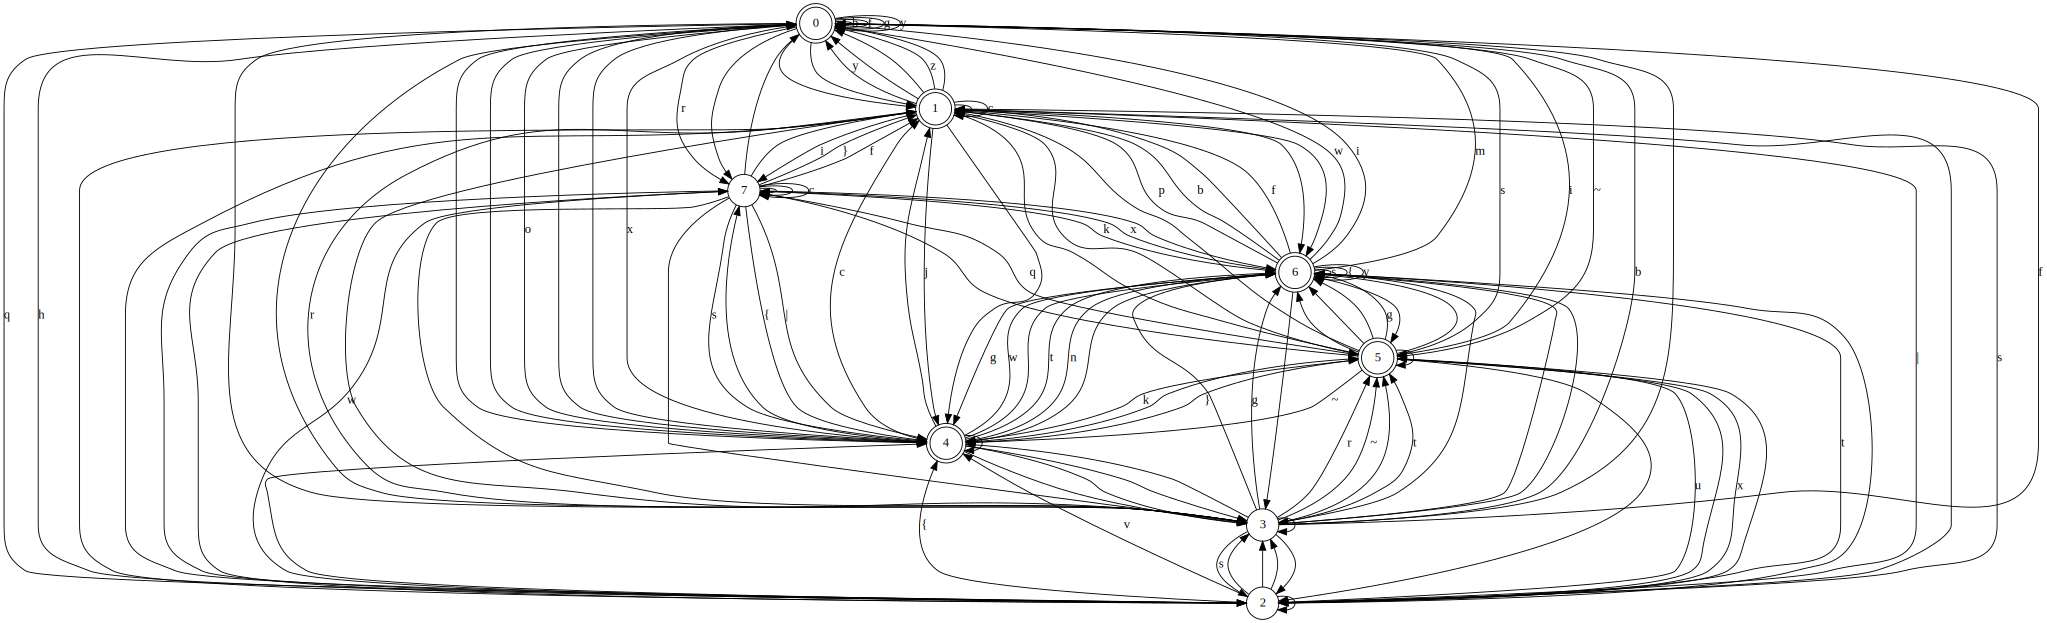


GT  is 2
ctx is ['\x81', '\x86', 'f', '\x89', '\x8e', 'z', 'o', 't', 'f', 'q']
{5: 0.2760051509514952, 2: 0.7239948490485048}
Counter({2: 15180, 5: 5787})
{0: 0.23253149853196886, 4: 0.12757707163421794, 2: 0.07983310053875317, 1: 0.13689657506912573, 5: 0.09863779538781677, 6: 0.14362386334483054, 3: 0.09929163934893533, 7: 0.08160845614435164}
Counter({0: 261038, 6: 161231, 1: 153679, 4: 143217, 3: 111464, 5: 110730, 7: 91613, 2: 89620})

GT  is 4
ctx is ['\x95']
{3: 0.5523391229120915, 4: 0.4476608770879084}
Counter({3: 8300, 4: 6727})
{0: 0.23253149853196886, 4: 0.12757707163421794, 2: 0.07983310053875317, 1: 0.13689657506912573, 5: 0.09863779538781677, 6: 0.14362386334483054, 3: 0.09929163934893533, 7: 0.08160845614435164}
Counter({0: 261038, 6: 161231, 1: 153679, 4: 143217, 3: 111464, 5: 110730, 7: 91613, 2: 89620})

GT  is 4
ctx is ['q', '\x8e', '\x9d', 'n', '\x99', 'y', 'h', '\x96', 'f', '\x98', 'm', '\x8d', '\x82', '\x82', '\x82', 't', '\x8d', 'm', 'r', 'f', 'y', 'v']
{4: 1.0

nearest_rep_with_in_edge 0.64
nearest_state_with_in_edge 0.71
oracle_out_edge 0.93
oracle_in_edge 0.99
both_edges 0.7


 80%|████████  | 8/10 [05:14<01:17, 38.83s/it]

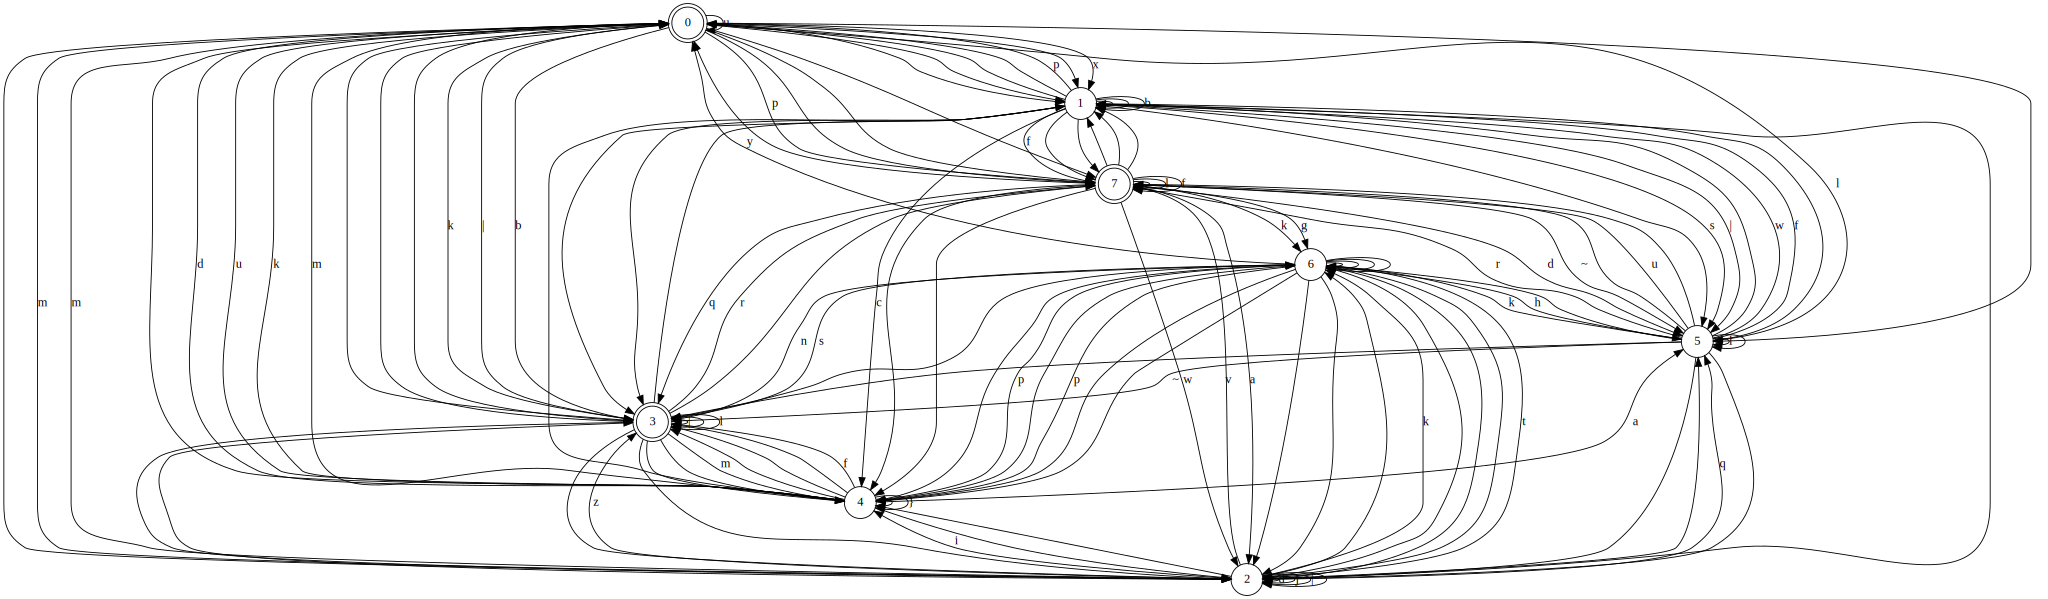


GT  is 6
ctx is ['\x8b', '\x8c', 'f', 'w', '\x87']
{6: 0.41891014434843415, 0: 0.5810898556515659}
Counter({0: 11634, 6: 8387})
{0: 0.1549937767013153, 1: 0.11842909364102219, 7: 0.12866179455265134, 5: 0.09700426660387303, 2: 0.14455783743173994, 6: 0.1105133100099797, 3: 0.1417531480920824, 4: 0.1040867729673361}
Counter({0: 221160, 2: 206269, 3: 202267, 7: 183587, 1: 168986, 6: 157691, 4: 148521, 5: 138415})

GT  is 3
ctx is ['\x81', '\x81', '\x9c', '\x9f', 'b']
{1: 0.4454753376774695, 3: 0.5545246623225305}
Counter({3: 12850, 1: 10323})
{0: 0.1549937767013153, 1: 0.11842909364102219, 7: 0.12866179455265134, 5: 0.09700426660387303, 2: 0.14455783743173994, 6: 0.1105133100099797, 3: 0.1417531480920824, 4: 0.1040867729673361}
Counter({0: 221160, 2: 206269, 3: 202267, 7: 183587, 1: 168986, 6: 157691, 4: 148521, 5: 138415})

GT  is 7
ctx is ['\x8b', '\x91', '\x8b', 'p', '\xa0']
{7: 0.5242147189282158, 4: 0.4757852810717842}
Counter({7: 11582, 4: 10512})
{0: 0.1549937767013153, 1: 0.1184

random_out_edge 0.13
random_in_edge 0.6
labeled_most_in_edges 0.66
nearest_rep_with_in_edge 0.67
nearest_state_with_in_edge 0.67
oracle_out_edge 0.94
oracle_in_edge 0.96
both_edges 0.73


 90%|█████████ | 9/10 [05:51<00:38, 38.28s/it]

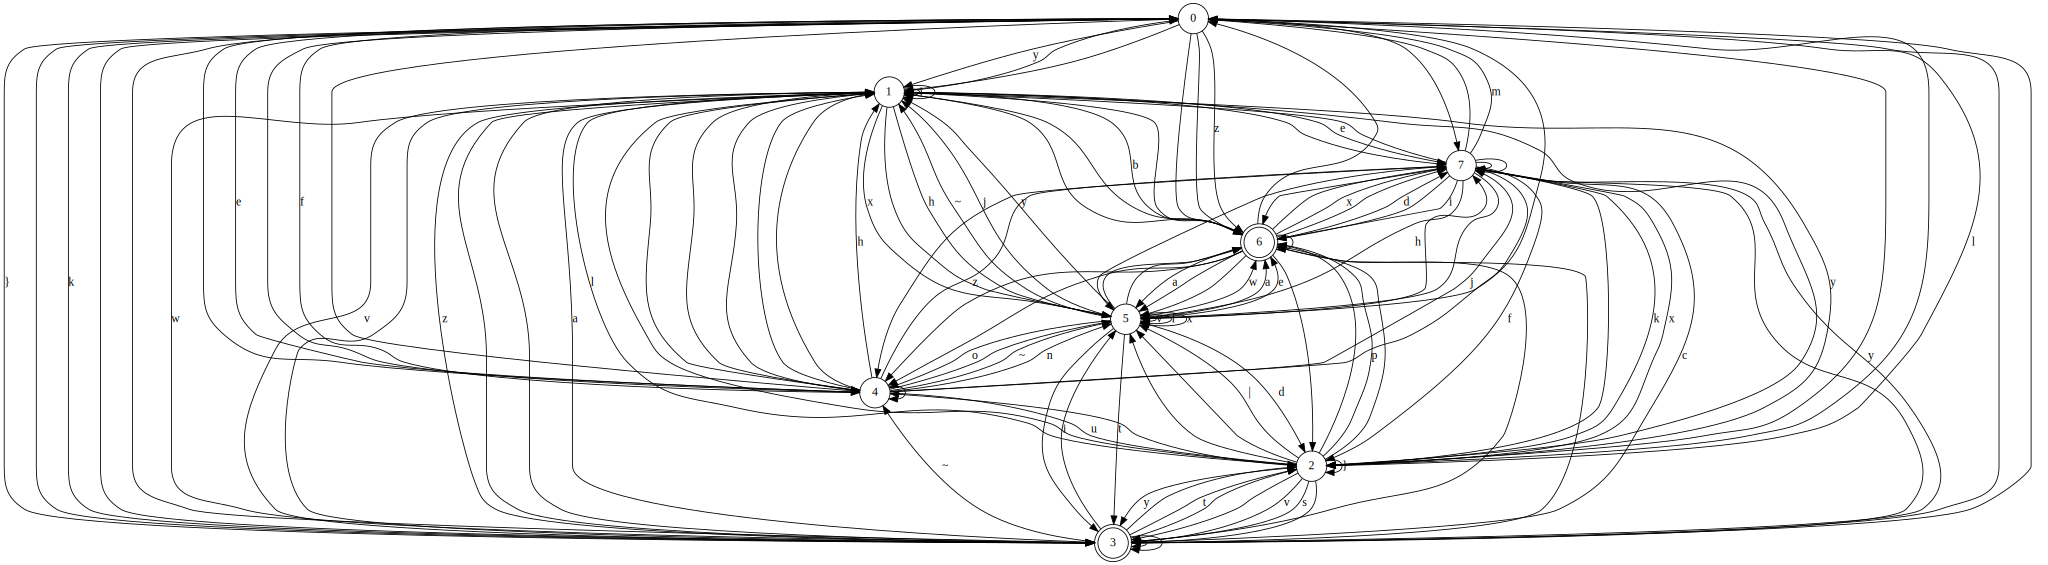


GT  is 5
ctx is ['\x81', '\x94', 'a', 'o', '\x92', 'l', '\x92', '\x85', 'p', '\x80', 't', '\x99']
{5: 0.5244186557650886, 2: 0.47558134423491144}
Counter({5: 11930, 2: 10819})
{0: 0.10628604579735863, 7: 0.11792003256614389, 2: 0.11358356774781714, 5: 0.1501101788700328, 6: 0.13331643273969998, 1: 0.15564837339911564, 3: 0.14576396370922529, 4: 0.07737140517060662}
Counter({1: 255414, 5: 246326, 3: 239194, 6: 218768, 7: 193503, 2: 186387, 0: 174412, 4: 126964})

GT  is 5
ctx is ['k', '\x83', 'm', '\x90', 'z', 'x', 'j', '\x82', '\x9c', '\x95', 'a', '\x9b', '~', 'z', 'i', '\x8e', 'h', '\x8b', 'y', 't', 's', '\x97', '\x9b', '\x8c', '\x99']
{5: 0.5244186557650886, 2: 0.47558134423491144}
Counter({5: 11930, 2: 10819})
{0: 0.10628604579735863, 7: 0.11792003256614389, 2: 0.11358356774781714, 5: 0.1501101788700328, 6: 0.13331643273969998, 1: 0.15564837339911564, 3: 0.14576396370922529, 4: 0.07737140517060662}
Counter({1: 255414, 5: 246326, 3: 239194, 6: 218768, 7: 193503, 2: 186387, 0: 174412

nearest_rep_with_in_edge 0.6
nearest_state_with_in_edge 0.6
oracle_out_edge 1.0
oracle_in_edge 0.96
both_edges 0.64


100%|██████████| 10/10 [06:30<00:00, 39.04s/it]


In [52]:
results2b = []
hyp_rand = np.random.RandomState(0)

def identity_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    return true_states[-1]

def most_in_edges_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    counts = [0 for _ in range(dfa.n_states)]
    for state_edges in dfa.edges:
        for _, nstate in state_edges:
            if nstate is None:
                continue
            counts[nstate] += 1
    return np.argmax(counts)

def random_out_edge_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    state_edges = dfa.edges[true_states[-1]]
    return state_edges[hyp_rand.randint(len(state_edges))][1]
    
def random_in_edge_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    if len(reachable) == 0:
        return hyp_rand.randint(dfa.n_states)
    else:
        return hyp_rand.choice(reachable)
    
def both_edges_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    reachable_out = [s for _, s in dfa.edges[true_states[-1]]]
    reachable_in = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    reachable_both = list(set(reachable_in) & set(reachable_out))
    if len(reachable_both) > 0:
        return hyp_rand.choice(reachable_both)
    elif len(reachable_in) > 0:
        return hyp_rand.choice(reachable_in)
    else:
        return hyp_rand.choice(reachable_out)
    
def labeled_most_in_edges_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    dist = dfa.stationary_dist()
    reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    if len(reachable) == 0:
        return hyp_rand.randint(dfa.n_states)
    return max(reachable, key=lambda x: dist[x])
    
def oracle_in_edge_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    if len(reachable) == 0:
        return hyp_rand.randint(dfa.n_states)
    elif pred_states[-1] not in reachable:
        return hyp_rand.randint(dfa.n_states)
    else:
        return pred_states[-1]
    
def oracle_out_edge_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    reachable = [dst for symb, dst in dfa.edges[true_states[-1]]]
    in_reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    #print("true states", true_states)
    #print("symbols", symbols)
    #print("reachable / in_reachable", reachable, in_reachable)
    #display(dfa.render())
    #assert len(set(reachable) & set(in_reachable)) == 0
    if len(reachable) == 0:
        return hyp_rand.randint(dfa.n_states)
    elif pred_states[-1] not in reachable:
        return hyp_rand.randint(dfa.n_states)
    else:
        return pred_states[-1]
    
def nearest_rep_with_in_edge_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    if len(reachable) == 0:
        reachable = list(range(dfa.n_states))
    return min(reachable, key=lambda nstate: (probe.means[pred_states[-2]] - probe.means[nstate]).norm())

def nearest_state_with_in_edge_hyp(dfa, pred_states, true_states, symbols, probe, **kwargs):
    reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    if len(reachable) == 0:
        reachable = list(range(dfa.n_states))
    return min(reachable, key=lambda nstate: dfa.distances[pred_states[-2]][nstate])

def copycat_hyp(dfa, pred_states, true_states, symbols, probe, ngram, copycat_states, **kwargs):
    return copycat_states[-1]

def make_ngram_hyp(order):
    def ngram_hyp(dfa, pred_states, true_states, symbols, probe, ngram, **kwargs):
        print("\nGT  is", pred_states[-1])
        print("ctx is", [chr(ord('a') + s) for s in symbols])
        return(ngram(symbols[-order:]))
    return ngram_hyp

dfa_rand = np.random.RandomState(0)
for i in tqdm(range(10)):
    dfa = Dfa.generate(dfa_rand, N_STATES, N_SYMBOLS, N_CONNECTIONS)
    display(dfa.render())
    hypotheses = [
        ("ngram1", make_ngram_hyp(1)),
        ("ngram2", make_ngram_hyp(2)),
        ("ngram3", make_ngram_hyp(3)),
        ("copycat", copycat_hyp),
        ("identity", identity_hyp),
        ("random_out_edge", random_out_edge_hyp),
        ("random_in_edge", random_in_edge_hyp),
        ("labeled_most_in_edges", labeled_most_in_edges_hyp),
        ("nearest_rep_with_in_edge", nearest_rep_with_in_edge_hyp),
        ("nearest_state_with_in_edge", nearest_state_with_in_edge_hyp),
        ("oracle_out_edge", oracle_out_edge_hyp),
        ("oracle_in_edge", oracle_in_edge_hyp),
        ("both_edges", both_edges_hyp)
    ]
    data_rand = np.random.RandomState(0)
    results2b += run_experiment2b(dfa, data_rand, hypotheses)
    
results2b = pd.DataFrame(results2b)

{'ngram1': 0.725, 'ngram2': 0.737, 'ngram3': 0.7409999999999999, 'copycat': 0.8459999999999999, 'identity': 0.12599999999999997, 'random_out_edge': 0.148, 'random_in_edge': 0.6759999999999999, 'labeled_most_in_edges': 0.6440000000000001, 'nearest_rep_with_in_edge': 0.6539999999999999, 'nearest_state_with_in_edge': 0.675, 'oracle_out_edge': 0.953, 'oracle_in_edge': 0.977, 'both_edges': 0.69}


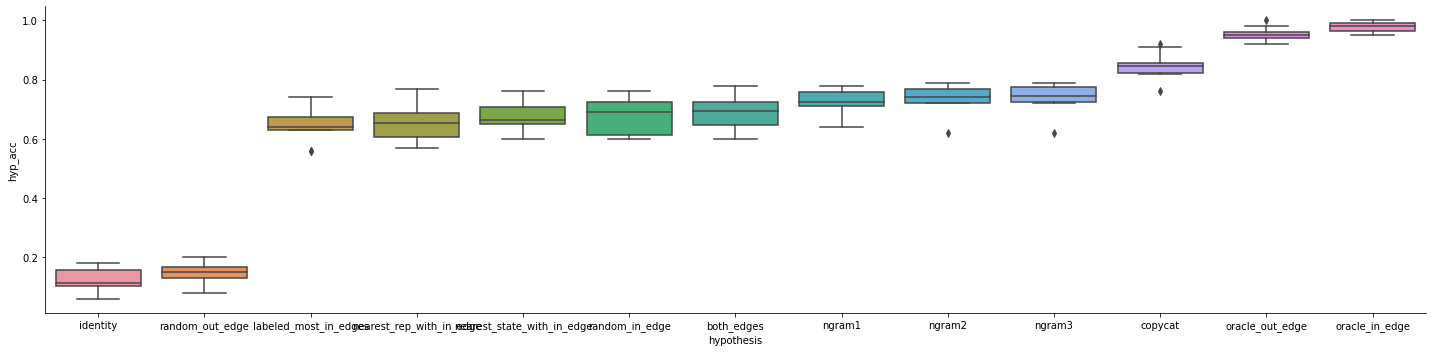

In [53]:
hyp_names = [name for name, _ in hypotheses]
hyp_means = {name: results2b[results2b["hypothesis"] == name]["hyp_acc"].mean() for name in hyp_names}
print(hyp_means)
ordered_names = sorted(hyp_names, key=lambda name: hyp_means[name])
sns.catplot(data=results2b, x="hypothesis", y="hyp_acc", aspect=4, kind="box", order=ordered_names)